## Matrix Games
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We are interested in the following min-max matrix game
\begin{equation}
    \min_{x \in \D_n}\max_{y\in \D_m} \lr{Ax, y},
\end{equation}
where $x\in \R^n$, $y\in \R^m$, $A\in \R^{m\times n}$, and $\Delta_m$,
$\D_n$ denote the standard unit simplices in $\R^m$ and $\R^n$
respectively.


In [1]:
import matplotlib.pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as la

from opt_operators import *
from methods.pd_algorithms import *
from methods.gr_pd_algorithms import *
from methods.adaptive_PDAc import *
%reload_ext autoreload
%autoreload 2

Choose any generator for random generation of data. In the paper we set gen = 50

In [2]:
gen = 1

Define matrix $A\in \R^{m\times n}$ (choose one of four possible examples below or generate a new instance):

In [3]:
case = 1
m = 100
n = 500
np.random.seed(gen)
A = np.random.normal(0, 10, [m, n])

In [85]:
case = 2
m = 100
n = 100
np.random.seed(gen)
A = np.random.uniform(-1, 1, [m,n])

In [96]:
case = 3
m = 100
n = 100
s = int(0.1*n)
np.random.seed(gen)
B = np.random.normal(0,1, (m,n))
p = 0.9
A = np.zeros((m,n))
A[:,0] = B[:,0]/np.sqrt(1-p**2)
for j in np.arange(1,n):
    A[:,j] = p*A[:,j-1] + B[:,j]
    
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

Define the starting points $x^0$ and $y^0$

In [4]:
x0 = np.ones(n)/n
y0 = np.ones(m)/m

Define all proximal operators, primal-dual gap, etc.

In [5]:
# define general proximal operator. Note that it is independent of 
# the dimension, so we will use it for both primal and dual variables
def prox_g(x, rho):
    return proj_simplex(x)

# define primal-dual gap
def J_gap(x,y, min_val):
    return max(A.dot(x)) - min(A.T.dot(y))

def J_gap1(y,x,min_val):
    return J_gap(x,y,min_val)

Compute the matrix norm of operator $A$. Define stepsizes for primal-dual method. 

In [6]:
# step size for PDAc
#L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))
L = np.sqrt(np.max(la.eigsh(A.dot(A.T))[0])) # this is for sparse matrix
print(L)


321.10792362998166


Run the algorithms: PDAc and SF-PDAc

In [7]:
# Run PDAc
N = 300000
T = 1e-8
min_val = 0

phi_f = 1.1
delta = phi_f*(2+2*phi_f-phi_f**2)/(1+phi_f)
sqrt_delta = np.sqrt(delta)
print(m)

if case == 3:
    kk = 10
else:
    kk = 3
    
ratio = 1
    
tau_f = 1/ratio * kk * sqrt_delta/L
sigma_f = ratio * kk * sqrt_delta/L

if m <= n:
    #ans4 = pd_free_PDAc_adaptive_MMG(J_gap, prox_g, prox_g, A, x0, y0, sigma_f, tau_f, phi_f, min_val, numb_iter=N, tol=T)
    ans1 = pd_free_Golden(J_gap, prox_g, prox_g, A, x0, y0, sigma_f, tau_f, phi_f, min_val, numb_iter=N, tol=T)
else:
    #ans4 = pd_free_PDAc_adaptive_MMG(J_gap1, prox_g, prox_g, -A.T, y0, x0,  tau_f, sigma_f,  phi_f, min_val, numb_iter=N, tol=T)
    ans1 = pd_free_Golden(J_gap1, prox_g, prox_g, -A.T, y0, x0,  tau_f, sigma_f,   phi_f, min_val, numb_iter=N, tol=T)
          

100
1.5661904761904764
----- Stepfree Golden-Ratio PDA-----
Time execution: 101.28
iteration:
234364
opt:
9.959160829353664e-09
error:
9.959160829353664e-09


In [8]:
# Run PDAc
phi = 1.1
delta = phi*(2+2*phi-phi**2)/(1+phi)
sqrt_delta = np.sqrt(delta)

kk = 1
tau = 1/ratio * kk * sqrt_delta/L
sigma = ratio * kk * sqrt_delta/L
ans2 = pd_Golden(J_gap, prox_g, prox_g, A, x0, y0, sigma, tau,phi, min_val, numb_iter=N,tol=T)


Golden-Ratio PDA does not terminate after 90.39 seconds
2.8636092608280705e-08


Plots of the primal-dual gap vs. CPU time(seconds):

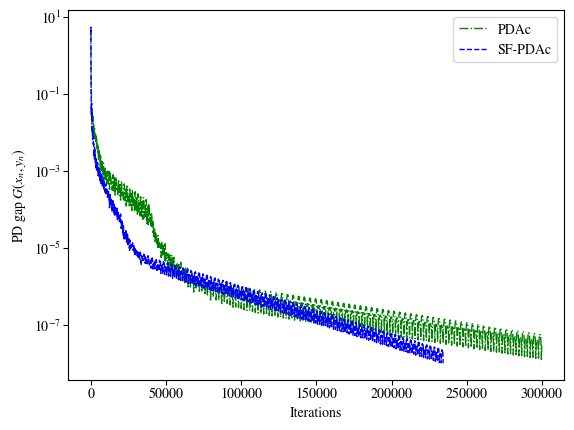

In [9]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1)
mpl.rcParams.update(
    {'font.size': 10, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

plt.plot(ans2[0], 'g-.', label = 'PDAc')
plt.plot(ans1[0], 'b--', label = 'SF-PDAc')

plt.yscale('log')
plt.xlabel(u'Iterations')
plt.ylabel(u'PD gap $G(x_n,y_n)$')


plt.legend()
#plt.savefig('figures/MM-1-iter.pdf')
plt.show()

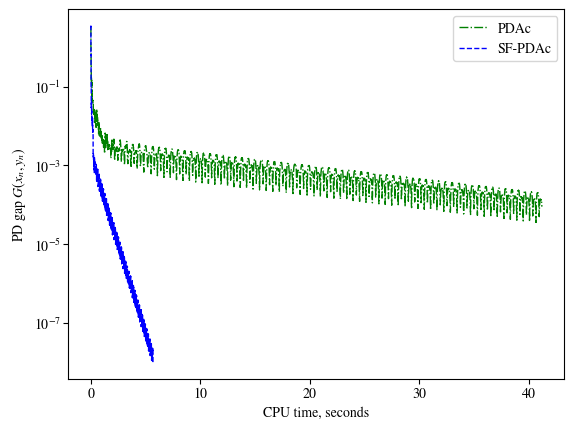

In [102]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1)
mpl.rcParams.update(
    {'font.size': 10, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

plt.plot(ans2[-1], ans2[0], 'g-.', label = 'PDAc')
plt.plot(ans1[-1], ans1[0], 'b--', label = 'SF-PDAc')



plt.yscale('log')
plt.xlabel(u'CPU time, seconds')
plt.ylabel(u'PD gap $G(x_n,y_n)$')

plt.legend()
plt.savefig('figures/MM-113-time.pdf')
plt.show()

In [21]:
print(L)

10.825189694331257
